In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer

2023-05-25 23:32:25.762081: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-25 23:32:25.798244: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-25 23:32:25.798764: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 23:32:26.414734: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 1. Introduction

In this lab, you will see the power of word embeddings, and how embeddings can be used in different applications.

Summarize the papers that were distributed with the module.

# Summary of Effective Approaches to Attention-based Neural Machine Translation(1508.04025)
This paper, authored by Minh-Thang Luong, Hieu Pham, and Christopher D. Manning, investigates effective approaches to attention-based neural machine translation (NMT). The authors aim to improve the performance and efficiency of NMT systems by proposing novel modifications to the attention mechanism.

The paper begins by providing an overview of the attention mechanism, which allows NMT models to focus on different parts of the source sentence during the translation process. The authors discuss the limitations of the standard attention mechanism, such as its computational complexity and difficulties in handling long sentences.

To address these limitations, the authors propose several modifications to the attention mechanism. Firstly, they introduce a self-attention mechanism that enables the model to attend to different parts of the source sentence simultaneously. This modification enhances translation quality and helps capture long-range dependencies more effectively.

Secondly, the authors propose a coverage mechanism that prevents repeated or neglected translation of certain source words. By keeping track of the attention history, the coverage mechanism encourages the model to attend to less-covered words, leading to improved translation accuracy and reduced translation repetition.

Additionally, the authors introduce a combination of local and global attention mechanisms. The local attention mechanism restricts the model's attention to a small window around the current target position, reducing computational burden and enhancing efficiency. The global attention mechanism is employed when attending to the entire source sentence is necessary, ensuring important contextual information is captured.

The authors evaluate their proposed approaches using various benchmark datasets and compare them with existing state-of-the-art methods. Experimental results demonstrate that the proposed modifications significantly enhance translation quality while achieving competitive performance with reduced computational costs.

In conclusion, this paper presents effective approaches to attention-based NMT, addressing the limitations of the standard attention mechanism and improving translation performance. The proposed modifications, including self-attention, coverage mechanism, and a combination of local and global attention, contribute to improved translation accuracy, reduced repetition, and increased efficiency in NMT systems.

# Summary of Attention Is All You Need (1706.03762)

The paper highlights the limitations of previous sequence-to-sequence models, such as their sequential nature and difficulties in parallelization. The authors propose the Transformer model as an alternative, emphasizing the importance of self-attention, which allows the model to attend to different positions in the input sequence to generate the output.

The Transformer architecture consists of an encoder and a decoder, both composed of stacked layers of self-attention and feed-forward neural networks. The self-attention mechanism allows the model to capture relationships between different positions in the input sequence, while the feed-forward networks provide non-linear transformations.

To enhance the self-attention mechanism, the authors introduce multi-head attention, where multiple attention functions are executed in parallel. This allows the model to attend to different information at different positions, facilitating better representation learning.

The authors conduct extensive experiments on various machine translation tasks and compare the Transformer model's performance against existing state-of-the-art methods. The results demonstrate that the Transformer achieves superior translation quality while also improving training efficiency. The model can handle long-range dependencies more effectively, and its parallelizable nature enables faster training times.

Furthermore, the authors analyze the attention patterns learned by the Transformer and find that it exhibits strong linguistic properties. The model can focus on relevant source words during translation and exhibits interpretability in understanding the relationships between different words.

In conclusion, this paper presents the Transformer model as a groundbreaking approach for sequence-to-sequence tasks. By relying solely on the attention mechanism, the Transformer achieves superior performance in machine translation while being highly parallelizable and efficient. The authors' proposed architecture represents a significant advancement in the field of neural networks and provides a new perspective on sequence processing tasks.

# Summary of Deep contextualized word representations(1802.05365)
The authors argue that traditional word embeddings, such as Word2Vec or GloVe, fail to capture the nuances of word meanings as they treat each word as a static entity. In contrast, ELMo is a bi-directional language model that takes into account the surrounding context of a word to generate dynamic word representations.

The ELMo model is composed of a character-level convolutional neural network (CNN) followed by a bi-directional LSTM (Long Short-Term Memory) network. The character-level CNN captures sub-word information, while the LSTM processes the contextual information by considering both preceding and succeeding words in a sentence.

To evaluate the effectiveness of ELMo, the authors conduct experiments on a range of natural language processing (NLP) tasks, including question answering, sentiment analysis, and named entity recognition. The results demonstrate that ELMo consistently outperforms traditional word embeddings, showcasing its ability to capture context-dependent word representations.

Furthermore, the authors examine the interpretability of ELMo by analyzing the attention weights of the model. They find that ELMo attends to different parts of the input sentence, aligning with syntactic and semantic cues, thus providing insights into the model's decision-making process.

The authors also compare ELMo with other contextual word representation models, such as OpenAI's GPT, and highlight the advantages of ELMo, including its ability to handle out-of-vocabulary words and its compatibility with a wide range of downstream NLP tasks.

In conclusion, this paper introduces ELMo as a powerful approach for generating deep contextualized word representations. By considering the surrounding context of a word, ELMo captures the nuances of word meanings and outperforms traditional static word embeddings in various NLP tasks. The authors' work contributes to the advancement of NLP models that can effectively capture the contextual semantics of words.

# 2. GloVe

We will first read imdb movie reviews to train a GloVe embeddings.

GloVe is computed from a co-occurrence matrix $X$ as follows:

$
J = \sum_{i=1,j=1}^{V,V} f(X_{ij}) (w_i^T w_j + b_i + b_j - log(X_{ij}))^2
$

$f(X_{ij}) = (X_{ij} / X_{\max})^\alpha$ if $X_{ij} < X_{\max}$; otherwise it is $1$.

$
\nabla_{w_i} J = f(X_{ij}) w_j (w_i^T w_j + b_i + b_j - log(X_{ij}))
$

$
\nabla_{w_j} J = f(X_{ij}) w_i (w_i^T w_j + b_i + b_j - log(X_{ij}))
$

$
\nabla_{b_i} J = \nabla_{b_j} J = f(X_{ij}) (w_i^T w_j + b_i + b_j - log(X_{ij}))
$

In [325]:
from keras import preprocessing
from keras.datasets import imdb
from random import shuffle

In [330]:
start_char = 1
oov_char = 2
index_from = 3

(x_train, _), _ = imdb.load_data(
    start_char=start_char, oov_char=oov_char, index_from=index_from
)

word_index = imdb.get_word_index()
inverted_word_index = dict(
    (i + index_from, word) for (word, i) in word_index.items()
)
# Update `inverted_word_index` to include `start_char` and `oov_char`
inverted_word_index[start_char] = "[START]"
inverted_word_index[oov_char] = "[OOV]"
vocab_size = max(word_index.values()) + index_from

decoded_sequence = " ".join(inverted_word_index[i] for i in x_train[0])
decoded_sequence

"[START] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and sh

In [331]:
from tqdm import tqdm
import os

window = 10
left_window = window // 2
right_window = window - left_window

def gen_X():
    if os.path.exists('indexes.npy') and os.path.exists('X.npy'): return
    X = np.zeros((vocab_size, vocab_size), dtype=np.float32)
    indexes = set()
    for s in tqdm(x_train):
        for i in range(len(s)):
            w = s[i]
            j_indexes = np.concatenate([
                np.arange(max(0, i - left_window), i),
                np.arange(i+1, min(len(s), i + right_window + 1))])
            for j in j_indexes:
                d = 1.0 / (j - i)
                c = s[j]
                X[w, c] += d
    indexes = []
    all_idx = np.arange(vocab_size)
    for i in tqdm(range(vocab_size)):
        mask = X[i] != 0
        if np.sum(mask) == 0: continue
        for j in all_idx[mask]:
            indexes.append((i, j))

    indexes = np.array(indexes, dtype=np.int64)

    # generate f function
    np.save('X.npy', X.astype(np.float32))
    np.save('indexes.npy', indexes)

gen_X()

In [332]:
embedding_size = 50

In [333]:
class Glove(torch.nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.W = torch.nn.Embedding(vocab_size, embedding_size)
        self.C = torch.nn.Embedding(vocab_size, embedding_size)
        self.b_w = torch.nn.Embedding(vocab_size, 1)
        self.b_c = torch.nn.Embedding(vocab_size, 1)

    def loss(self, index, Xij, Xmax=1000, alpha=0.75):
        i = index[:, 0]
        j = index[:, 1]

        f = torch.where(Xij < Xmax, torch.pow(Xij / Xmax, alpha), 1)
        loss = f * torch.pow(
            torch.einsum('ij,ij->i', self.W(i), self.C(j)) +
            self.b_w(i) + self.b_c(j) - torch.log10(Xij + 1e-6), 2)
        
        return loss.mean()

In [334]:
glove = Glove(vocab_size, embedding_size)

# load but leave vectors in disk
X = np.load('X.npy', mmap_mode='r')
indexes = np.load('indexes.npy', mmap_mode='r')

shuffle_idx = np.arange(len(indexes))
np.random.shuffle(shuffle_idx)

In [337]:
device = 'cuda'

In [338]:
glove = glove.to(device)

print('... done wth transferring to device')

... done wth transferring to device


In [339]:
optimizer = torch.optim.Adagrad(glove.parameters(), lr=0.005, weight_decay=0.95)

good = torch.tensor(word_index['good'] + index_from, dtype=torch.int64).to('cuda')
bad = torch.tensor(word_index['bad'] + index_from, dtype=torch.int64).to('cuda')

epochs = 1000
batch_size = 8192
Xmax = 1000.0
for epoch in range(epochs):
    print('epoch', epoch)
    np.random.shuffle(shuffle_idx)
    loss_v = []
    for i in tqdm(range(0, len(shuffle_idx), batch_size)):
        index_batch = shuffle_idx[i:i+batch_size]
        index_batch = np.array([indexes[ii] for ii in index_batch])
        X_batch = np.concatenate(
            [[X[ii,jj]] for ii, jj in index_batch ]).astype(np.float32)
        X_batch = np.clip(X_batch, 0.0, Xmax)
        index_batch = torch.from_numpy(np.array(index_batch).astype(np.int64)).to('cuda')
        X_batch = torch.from_numpy(X_batch.astype(np.float32)).to('cuda')
        loss = glove.loss(index_batch, X_batch, Xmax)
        loss_v.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad() 

    good_v = glove.W(good).detach().cpu().numpy()
    bad_v = glove.W(bad).detach().cpu().numpy()
    good_v = good_v / np.linalg.norm(good_v)
    bad_v = bad_v / np.linalg.norm(bad_v)
    
    print(f'... {epoch}: {np.mean(loss_v)} good.bad = {np.dot(good_v, bad_v)}')


epoch 0


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:04<00:00, 11.29it/s]


... 0: 0.06184001161693678 good.bad = -0.16627469658851624
epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.46it/s]


... 1: 0.03283541590982909 good.bad = -0.15351566672325134
epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:07<00:00, 11.05it/s]


... 2: 0.02242573002399711 good.bad = -0.14281664788722992
epoch 3


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.55it/s]


... 3: 0.016706906055560952 good.bad = -0.13329601287841797
epoch 4


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.60it/s]


... 4: 0.013116602670547164 good.bad = -0.12452743202447891
epoch 5


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.57it/s]


... 5: 0.010682313319534275 good.bad = -0.11630827188491821
epoch 6


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.52it/s]


... 6: 0.008961014386624416 good.bad = -0.1085629016160965
epoch 7


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.59it/s]


... 7: 0.007684926141477671 good.bad = -0.10127227753400803
epoch 8


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.54it/s]


... 8: 0.00671821344325657 good.bad = -0.09443525969982147
epoch 9


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.55it/s]


... 9: 0.005974018669876128 good.bad = -0.08805166184902191
epoch 10


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 10: 0.005387603892576864 good.bad = -0.08211478590965271
epoch 11


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.53it/s]


... 11: 0.0049193361651457285 good.bad = -0.07661351561546326
epoch 12


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.52it/s]


... 12: 0.004545493397258514 good.bad = -0.07152610272169113
epoch 13


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 13: 0.004230216894882111 good.bad = -0.06682711839675903
epoch 14


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.48it/s]


... 14: 0.003974505416962759 good.bad = -0.06249205768108368
epoch 15


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.52it/s]


... 15: 0.0037618163063313508 good.bad = -0.05849219858646393
epoch 16


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.48it/s]


... 16: 0.003580990970777712 good.bad = -0.054800961166620255
epoch 17


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 17: 0.0034303016605160574 good.bad = -0.051390692591667175
epoch 18


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.51it/s]


... 18: 0.003299934323462807 good.bad = -0.04823780059814453
epoch 19


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.52it/s]


... 19: 0.0031894945496447995 good.bad = -0.04531850665807724
epoch 20


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.49it/s]


... 20: 0.003098634185660564 good.bad = -0.04261215403676033
epoch 21


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.49it/s]


... 21: 0.0030123716498662145 good.bad = -0.0400984100997448
epoch 22


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 22: 0.0029404092122290245 good.bad = -0.03776006028056145
epoch 23


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.53it/s]


... 23: 0.002878035465711098 good.bad = -0.035581473261117935
epoch 24


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.39it/s]


... 24: 0.0028233407816793303 good.bad = -0.033548273146152496
epoch 25


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.42it/s]


... 25: 0.0027753432801662817 good.bad = -0.03164846450090408
epoch 26


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.43it/s]


... 26: 0.002733555209269462 good.bad = -0.02987028658390045
epoch 27


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.43it/s]


... 27: 0.002696505082552437 good.bad = -0.028203045949339867
epoch 28


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 28: 0.002661756169816539 good.bad = -0.026638351380825043
epoch 29


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.51it/s]


... 29: 0.0026312852838056766 good.bad = -0.02516823448240757
epoch 30


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.60it/s]


... 30: 0.0026042340301785922 good.bad = -0.02378476969897747
epoch 31


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.54it/s]


... 31: 0.0025802644097256172 good.bad = -0.02248217537999153
epoch 32


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.52it/s]


... 32: 0.0025590359797581924 good.bad = -0.021254345774650574
epoch 33


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.55it/s]


... 33: 0.002540132436848302 good.bad = -0.02009601704776287
epoch 34


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.58it/s]


... 34: 0.0025220014918032117 good.bad = -0.019002659246325493
epoch 35


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.53it/s]


... 35: 0.002507793524276028 good.bad = -0.017969703301787376
epoch 36


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.55it/s]


... 36: 0.0024911268301444044 good.bad = -0.01699391007423401
epoch 37


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.53it/s]


... 37: 0.002477684841753113 good.bad = -0.01607082039117813
epoch 38


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.51it/s]


... 38: 0.002466369124280216 good.bad = -0.015197926200926304
epoch 39


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.54it/s]


... 39: 0.0024546819195496016 good.bad = -0.01437161210924387
epoch 40


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.57it/s]


... 40: 0.002444637381658952 good.bad = -0.013590095564723015
epoch 41


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.54it/s]


... 41: 0.0024352440332954094 good.bad = -0.012850021943449974
epoch 42


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.52it/s]


... 42: 0.0024271662973010004 good.bad = -0.01214936189353466
epoch 43


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.53it/s]


... 43: 0.002419657631672826 good.bad = -0.011485908180475235
epoch 44


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.49it/s]


... 44: 0.0024114780078080293 good.bad = -0.010857590474188328
epoch 45


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.51it/s]


... 45: 0.0024058986855819953 good.bad = -0.0102623850107193
epoch 46


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.56it/s]


... 46: 0.0024008205355628928 good.bad = -0.009698954410851002
epoch 47


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.54it/s]


... 47: 0.0024008469119605035 good.bad = -0.009165276773273945
epoch 48


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.56it/s]


... 48: 0.0023917705413481066 good.bad = -0.008659976534545422
epoch 49


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 49: 0.002382972323935598 good.bad = -0.008181423880159855
epoch 50


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.57it/s]


... 50: 0.002378506304818832 good.bad = -0.007728429511189461
epoch 51


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.52it/s]


... 51: 0.002373945021345628 good.bad = -0.007299182936549187
epoch 52


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.53it/s]


... 52: 0.0023699274172283894 good.bad = -0.006893124897032976
epoch 53


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 53: 0.0023664947867217834 good.bad = -0.006508811842650175
epoch 54


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 54: 0.0023629183762498016 good.bad = -0.006144938059151173
epoch 55


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.53it/s]


... 55: 0.002361198613797961 good.bad = -0.005800737999379635
epoch 56


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.49it/s]


... 56: 0.0023565654447749657 good.bad = -0.005475009325891733
epoch 57


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.54it/s]


... 57: 0.0023572159112427793 good.bad = -0.005166980437934399
epoch 58


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 58: 0.0023509283289495603 good.bad = -0.004875499289482832
epoch 59


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.54it/s]


... 59: 0.002348586281900728 good.bad = -0.004599790554493666
epoch 60


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 60: 0.002346588671746004 good.bad = -0.004339195322245359
epoch 61


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.56it/s]


... 61: 0.0023440480734771814 good.bad = -0.004092821851372719
epoch 62


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.51it/s]


... 62: 0.002342352884559763 good.bad = -0.0038598619867116213
epoch 63


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.53it/s]


... 63: 0.0023400176778846683 good.bad = -0.003639683360233903
epoch 64


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.53it/s]


... 64: 0.0023380426468751873 good.bad = -0.0034317560493946075
epoch 65


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 65: 0.002336854220399454 good.bad = -0.0032351731788367033
epoch 66


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.54it/s]


... 66: 0.002340975999451007 good.bad = -0.0030495894607156515
epoch 67


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.51it/s]


... 67: 0.0023338861852549545 good.bad = -0.0028741464484483004
epoch 68


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.56it/s]


... 68: 0.0023316091136158412 good.bad = -0.00270856823772192
epoch 69


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.52it/s]


... 69: 0.0023307587698705202 good.bad = -0.002552198013290763
epoch 70


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.55it/s]


... 70: 0.0023362403530030914 good.bad = -0.0024046574253588915
epoch 71


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 71: 0.002327583792902781 good.bad = -0.002265272894874215
epoch 72


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.57it/s]


... 72: 0.0023271287703187306 good.bad = -0.002133830450475216
epoch 73


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.51it/s]


... 73: 0.0023255039315117237 good.bad = -0.0020097745582461357
epoch 74


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:06<00:00, 11.12it/s]


... 74: 0.0023242161200743077 good.bad = -0.0018926810007542372
epoch 75


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:04<00:00, 11.32it/s]


... 75: 0.0023250084698906177 good.bad = -0.001782265375368297
epoch 76


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.43it/s]


... 76: 0.002322684712683139 good.bad = -0.0016781097510829568
epoch 77


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.37it/s]


... 77: 0.002322253616182034 good.bad = -0.001579804695211351
epoch 78


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.42it/s]


... 78: 0.0023238329722270953 good.bad = -0.001487170229665935
epoch 79


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.48it/s]


... 79: 0.0023207886352492133 good.bad = -0.0013998467475175858
epoch 80


 38%|██████████████████████████████▋                                                 | 538/1405 [00:46<01:14, 11.70it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 97: 0.0023089442110464666 good.bad = -0.00046382189611904323
epoch 98


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 98: 0.002315790613108974 good.bad = -0.00043589455890469253
epoch 99


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.39it/s]


... 99: 0.0023082005143831765 good.bad = -0.0004095829790458083
epoch 100


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.33it/s]


... 100: 0.002308175325090417 good.bad = -0.000384836079319939
epoch 101


 97%|████████████████████████████████████████████████████████████████████████████▊  | 1366/1405 [01:59<00:03, 11.31it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 119: 0.0023059199682645684 good.bad = -0.00011641556193353608
epoch 120


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.49it/s]


... 120: 0.002302952727934286 good.bad = -0.00010934851161437109
epoch 121


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.44it/s]


... 121: 0.0023050016979604057 good.bad = -0.00010255706729367375
epoch 122


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.46it/s]


... 122: 0.0023033270836489614 good.bad = -9.628260158933699e-05
epoch 123


 52%|█████████████████████████████████████████▌                                      | 730/1405 [01:03<00:48, 14.04it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:06<00:00, 11.10it/s]


... 127: 0.0023025936845216064 good.bad = -6.989189569139853e-05
epoch 128


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:13<00:00, 10.56it/s]


... 128: 0.0023028118078086486 good.bad = -6.556971493409947e-05
epoch 129


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:04<00:00, 11.32it/s]


... 129: 0.0023016708184636836 good.bad = -6.151667184894904e-05
epoch 130


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.40it/s]


... 130: 0.0023035177714903956 good.bad = -5.766598405898549e-05
epoch 131


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.51it/s]


... 131: 0.0023033734443730068 good.bad = -5.404424882726744e-05
epoch 132


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.42it/s]


... 132: 0.0023016565010362568 good.bad = -5.063798380433582e-05
epoch 133


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 133: 0.0023022972453332563 good.bad = -4.744300895254128e-05
epoch 134


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:04<00:00, 11.31it/s]


... 134: 0.002301950070317636 good.bad = -4.4433141738409176e-05
epoch 135


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.39it/s]


... 135: 0.002302914966242487 good.bad = -4.158383308094926e-05
epoch 136


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.42it/s]


... 136: 0.002300971473800847 good.bad = -3.898052455042489e-05
epoch 137


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 137: 0.0023009651915992203 good.bad = -3.663507231976837e-05
epoch 138


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.46it/s]


... 138: 0.002300841137692266 good.bad = -3.4242792025906965e-05
epoch 139


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.45it/s]


... 139: 0.0023060917304132756 good.bad = -3.2142954296432436e-05
epoch 140


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 140: 0.0023017969632892475 good.bad = -3.0088347557466477e-05
epoch 141


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:04<00:00, 11.30it/s]


... 141: 0.002300801928887588 good.bad = -2.807796045090072e-05
epoch 142


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.49it/s]


... 142: 0.002300501585104486 good.bad = -2.6267125576850958e-05
epoch 143


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.46it/s]


... 143: 0.0023013750099480893 good.bad = -2.4622211640235037e-05
epoch 144


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.46it/s]


... 144: 0.0023007695131862264 good.bad = -2.299293191754259e-05
epoch 145


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.38it/s]


... 145: 0.0023008158636773236 good.bad = -2.1590465621557087e-05
epoch 146


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.52it/s]


... 146: 0.00230062863328809 good.bad = -2.0171866708551534e-05
epoch 147


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.44it/s]


... 147: 0.002299894809804101 good.bad = -1.8894610548159108e-05
epoch 148


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.53it/s]


... 148: 0.00230017354814634 good.bad = -1.7603510059416294e-05
epoch 149


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.49it/s]


... 149: 0.002300020314013963 good.bad = -1.642865208850708e-05
epoch 150


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.52it/s]


... 150: 0.0023000659841590056 good.bad = -1.545735176478047e-05
epoch 151


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.53it/s]


... 151: 0.00229996397169108 good.bad = -1.438150411559036e-05
epoch 152


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.55it/s]


... 152: 0.002300520705223229 good.bad = -1.3373020919971168e-05
epoch 153


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.38it/s]


... 153: 0.0022998948463858553 good.bad = -1.2557273294078186e-05
epoch 154


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.36it/s]


... 154: 0.0022996739768157996 good.bad = -1.171412441181019e-05
epoch 155


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.42it/s]


... 155: 0.002299553125241632 good.bad = -1.0927979019470513e-05
epoch 156


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.51it/s]


... 156: 0.002299521422283757 good.bad = -1.0223176104773302e-05
epoch 157


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 157: 0.002301259485928481 good.bad = -9.43692521104822e-06
epoch 158


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.52it/s]


... 158: 0.002300339062355154 good.bad = -8.812402484181803e-06
epoch 159


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.43it/s]


... 159: 0.0022996170447105242 good.bad = -8.102015272015706e-06
epoch 160


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 160: 0.0023006184943421375 good.bad = -7.632946108060423e-06
epoch 161


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.42it/s]


... 161: 0.002299982346461761 good.bad = -7.102598374331137e-06
epoch 162


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.49it/s]


... 162: 0.0022997085164132066 good.bad = -6.539940386574017e-06
epoch 163


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.33it/s]


... 163: 0.002299521016694433 good.bad = -6.0635616137005854e-06
epoch 164


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 164: 0.002299420779373735 good.bad = -5.530492671823595e-06
epoch 165


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 165: 0.0022997927007653166 good.bad = -5.108105597173562e-06
epoch 166


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.53it/s]


... 166: 0.0023023879527962797 good.bad = -4.834138053411152e-06
epoch 167


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.53it/s]


... 167: 0.0022993769843853823 good.bad = -4.515623913903255e-06
epoch 168


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.48it/s]


... 168: 0.00230163302491303 good.bad = -4.208957307128003e-06
epoch 169


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.48it/s]


... 169: 0.002298868199879986 good.bad = -3.88013449992286e-06
epoch 170


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.55it/s]


... 170: 0.002299336376235393 good.bad = -3.565148517736816e-06
epoch 171


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 171: 0.002299867890977377 good.bad = -3.249431301810546e-06
epoch 172


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.51it/s]


... 172: 0.002300071755666087 good.bad = -2.931324615929043e-06
epoch 173


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.46it/s]


... 173: 0.002299142224768846 good.bad = -2.6405755306768697e-06
epoch 174


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.53it/s]


... 174: 0.0022989226885063714 good.bad = -2.419164502498461e-06
epoch 175


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.54it/s]


... 175: 0.00229865120352226 good.bad = -2.1214636944932863e-06
epoch 176


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.42it/s]


... 176: 0.0022989145595683083 good.bad = -1.8918900650533033e-06
epoch 177


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.45it/s]


... 177: 0.002298954121181841 good.bad = -1.7257086710742442e-06
epoch 178


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 178: 0.002301026738391281 good.bad = -1.4455418977377121e-06
epoch 179


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.46it/s]


... 179: 0.002299195090996506 good.bad = -1.3544799912779126e-06
epoch 180


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 180: 0.0022987536603777114 good.bad = -1.0543221833358984e-06
epoch 181


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.45it/s]


... 181: 0.0022991388872948566 good.bad = -9.883931397780543e-07
epoch 182


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.46it/s]


... 182: 0.002298869516035986 good.bad = -8.582853752159281e-07
epoch 183


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.49it/s]


... 183: 0.0022990990117328154 good.bad = -7.100260290826554e-07
epoch 184


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.45it/s]


... 184: 0.0022984978407323093 good.bad = -5.91688717577199e-07
epoch 185


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.49it/s]


... 185: 0.0022987279217372056 good.bad = -3.8718729911124683e-07
epoch 186


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.49it/s]


... 186: 0.0022995671586736747 good.bad = -2.818236453094869e-07
epoch 187


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.53it/s]


... 187: 0.0022994350600951214 good.bad = -2.0340650053185527e-07
epoch 188


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.43it/s]


... 188: 0.0022985356684204097 good.bad = -1.1872771210619248e-08
epoch 189


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.45it/s]


... 189: 0.002303955914639931 good.bad = 1.436622483197425e-07
epoch 190


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.44it/s]


... 190: 0.0022991390714050667 good.bad = 1.5905447980912868e-07
epoch 191


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 191: 0.002299667791889324 good.bad = 1.8267900259161252e-07
epoch 192


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 192: 0.0023013157323847964 good.bad = 2.421153340037563e-07
epoch 193


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.51it/s]


... 193: 0.002300920289173868 good.bad = 2.9251822297737817e-07
epoch 194


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.46it/s]


... 194: 0.0022989154967737926 good.bad = 4.446232537702599e-07
epoch 195


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.51it/s]


... 195: 0.0022988516136795097 good.bad = 5.975403496449871e-07
epoch 196


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.45it/s]


... 196: 0.002298246377629967 good.bad = 7.501984669033845e-07
epoch 197


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.43it/s]


... 197: 0.0023010602476923755 good.bad = 7.419344001391437e-07
epoch 198


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 198: 0.002298666538879461 good.bad = 7.141638889152091e-07
epoch 199


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.48it/s]


... 199: 0.0022992746837791783 good.bad = 8.329081992997089e-07
epoch 200


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 200: 0.0022984349183751487 good.bad = 9.271614658246108e-07
epoch 201


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 201: 0.002299616269699341 good.bad = 9.594979246685398e-07
epoch 202


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 202: 0.002298222131218456 good.bad = 9.348420917376643e-07
epoch 203


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.42it/s]


... 203: 0.002299098137996468 good.bad = 1.0052392553916434e-06
epoch 204


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.42it/s]


... 204: 0.0022982181803061497 good.bad = 1.060965132637648e-06
epoch 205


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.51it/s]


... 205: 0.0022990650963038207 good.bad = 1.2530598496596212e-06
epoch 206


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.45it/s]


... 206: 0.0022985554795324457 good.bad = 1.3503881746146362e-06
epoch 207


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.46it/s]


... 207: 0.0022982535958770674 good.bad = 1.4709515880895196e-06
epoch 208


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.44it/s]


... 208: 0.002299354941206338 good.bad = 1.345128680441121e-06
epoch 209


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.51it/s]


... 209: 0.0022980260888729375 good.bad = 1.2852223107984173e-06
epoch 210


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 210: 0.0022984018123433578 good.bad = 1.446137389393698e-06
epoch 211


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.44it/s]


... 211: 0.0022982614500169705 good.bad = 1.3811572898703162e-06
epoch 212


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 212: 0.002299166169204812 good.bad = 1.4683780591440154e-06
epoch 213


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 213: 0.0022982689284378154 good.bad = 1.6085407423815923e-06
epoch 214


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 214: 0.0022982092893241617 good.bad = 1.5225584775180323e-06
epoch 215


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.45it/s]


... 215: 0.002298186620443834 good.bad = 1.6173355561477365e-06
epoch 216


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.53it/s]


... 216: 0.002300079499812154 good.bad = 1.5940775028866483e-06
epoch 217


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.43it/s]


... 217: 0.0022992455330097324 good.bad = 1.7251230701731401e-06
epoch 218


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.49it/s]


... 218: 0.0022985099025196612 good.bad = 1.817613792809425e-06
epoch 219


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.42it/s]


... 219: 0.0022980986318792947 good.bad = 1.7767016515790601e-06
epoch 220


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 220: 0.0022982955002143076 good.bad = 1.6916123968258034e-06
epoch 221


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.48it/s]


... 221: 0.0023003420142499974 good.bad = 1.822139893192798e-06
epoch 222


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 222: 0.0022982457233012865 good.bad = 1.7828360796556808e-06
epoch 223


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.39it/s]


... 223: 0.0022978328286671805 good.bad = 1.7896375084092142e-06
epoch 224


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 224: 0.0022982583382892756 good.bad = 1.8241514680994442e-06
epoch 225


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.48it/s]


... 225: 0.0022985600892477588 good.bad = 1.952331103893812e-06
epoch 226


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.41it/s]


... 226: 0.0022979268824078435 good.bad = 1.896848743854207e-06
epoch 227


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.46it/s]


... 227: 0.002297863341972325 good.bad = 1.917077497637365e-06
epoch 228


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.45it/s]


... 228: 0.002304514441713757 good.bad = 1.9930905637011165e-06
epoch 229


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.37it/s]


... 229: 0.002300039600552759 good.bad = 2.1856906187167624e-06
epoch 230


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.41it/s]


... 230: 0.002298807117092055 good.bad = 2.183081278417376e-06
epoch 231


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.44it/s]


... 231: 0.0022982924454099767 good.bad = 2.1990658751747105e-06
epoch 232


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.45it/s]


... 232: 0.002300415114040596 good.bad = 2.399132881691912e-06
epoch 233


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.41it/s]


... 233: 0.0022991310689495577 good.bad = 2.521550641176873e-06
epoch 234


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.46it/s]


... 234: 0.0022981650779749603 good.bad = 2.463755663484335e-06
epoch 235


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 235: 0.002298582635001276 good.bad = 2.4285350264108274e-06
epoch 236


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 236: 0.0022986899250190293 good.bad = 2.457737764416379e-06
epoch 237


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.41it/s]


... 237: 0.0022979321117758142 good.bad = 2.4302121346408967e-06
epoch 238


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.42it/s]


... 238: 0.0022980273956452824 good.bad = 2.4970981939986814e-06
epoch 239


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.46it/s]


... 239: 0.0022984139932803412 good.bad = 2.558761480031535e-06
epoch 240


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.51it/s]


... 240: 0.0023027614989894643 good.bad = 2.6605675884638913e-06
epoch 241


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.45it/s]


... 241: 0.0023023701035931334 good.bad = 2.7253126972937025e-06
epoch 242


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.52it/s]


... 242: 0.0022980343187111846 good.bad = 2.7515168312675087e-06
epoch 243


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.55it/s]


... 243: 0.002298271327339166 good.bad = 2.9196964987932006e-06
epoch 244


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.53it/s]


... 244: 0.0022983003688604965 good.bad = 2.8652636956394417e-06
epoch 245


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.49it/s]


... 245: 0.002297931204813456 good.bad = 2.753378112174687e-06
epoch 246


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.53it/s]


... 246: 0.002298290313683861 good.bad = 2.8090928481105948e-06
epoch 247


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.52it/s]


... 247: 0.002297811901894501 good.bad = 3.0129704100545496e-06
epoch 248


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.57it/s]


... 248: 0.002297797331501965 good.bad = 2.946097765743616e-06
epoch 249


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.55it/s]


... 249: 0.0022983212923395756 good.bad = 3.0510768738167826e-06
epoch 250


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.53it/s]


... 250: 0.0022979114568391253 good.bad = 3.1107458653423237e-06
epoch 251


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.51it/s]


... 251: 0.002297778991448736 good.bad = 3.2327229746442754e-06
epoch 252


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.51it/s]


... 252: 0.002299699112830942 good.bad = 3.3102901397796813e-06
epoch 253


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.51it/s]


... 253: 0.002298120917044779 good.bad = 3.4268821309524355e-06
epoch 254


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 254: 0.0022979251123563756 good.bad = 3.319839379400946e-06
epoch 255


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.46it/s]


... 255: 0.0022994145684298857 good.bad = 3.525334932419355e-06
epoch 256


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.53it/s]


... 256: 0.0022984697137962617 good.bad = 3.4665106340980856e-06
epoch 257


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 257: 0.002301927654816706 good.bad = 3.4631818834895967e-06
epoch 258


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.49it/s]


... 258: 0.002297737092662974 good.bad = 3.5174598451703787e-06
epoch 259


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.41it/s]


... 259: 0.0023017948477618475 good.bad = 3.6525132145470707e-06
epoch 260


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.49it/s]


... 260: 0.0022984651491556357 good.bad = 3.602588094508974e-06
epoch 261


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.45it/s]


... 261: 0.0022979816493124195 good.bad = 3.604467792683863e-06
epoch 262


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.41it/s]


... 262: 0.002303319806158476 good.bad = 3.544190349202836e-06
epoch 263


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.42it/s]


... 263: 0.0022979529457683823 good.bad = 3.6765170534636127e-06
epoch 264


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.38it/s]


... 264: 0.0022981971179572634 good.bad = 3.6204462503519608e-06
epoch 265


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.45it/s]


... 265: 0.002298546606199186 good.bad = 3.6362764603836695e-06
epoch 266


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.36it/s]


... 266: 0.002297917054427516 good.bad = 3.9201431718538515e-06
epoch 267


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:04<00:00, 11.29it/s]


... 267: 0.0022996876560718326 good.bad = 3.8306161513901316e-06
epoch 268


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.44it/s]


... 268: 0.0022985260631206354 good.bad = 3.996593932242831e-06
epoch 269


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 269: 0.002297699984802709 good.bad = 4.253151018929202e-06
epoch 270


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.37it/s]


... 270: 0.0023047830746674852 good.bad = 4.394413736008573e-06
epoch 271


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.46it/s]


... 271: 0.0022985341829443316 good.bad = 4.375204298412427e-06
epoch 272


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 272: 0.0022978717847346093 good.bad = 4.541679572866997e-06
epoch 273


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.43it/s]


... 273: 0.002298750364995525 good.bad = 4.6187751649995334e-06
epoch 274


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.48it/s]


... 274: 0.0022976582479419592 good.bad = 4.526021712081274e-06
epoch 275


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.38it/s]


... 275: 0.0022976188115473983 good.bad = 4.6101313273538835e-06
epoch 276


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.40it/s]


... 276: 0.0022976371341590436 good.bad = 4.67706968265702e-06
epoch 277


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.46it/s]


... 277: 0.0022976319330248957 good.bad = 4.633996468328405e-06
epoch 278


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.42it/s]


... 278: 0.002302339477911989 good.bad = 4.709467702923575e-06
epoch 279


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.39it/s]


... 279: 0.0022978343906832257 good.bad = 4.718973741546506e-06
epoch 280


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.38it/s]


... 280: 0.0022977858589584292 good.bad = 4.68135840492323e-06
epoch 281


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.41it/s]


... 281: 0.002297735387489226 good.bad = 4.8388151299150195e-06
epoch 282


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.41it/s]


... 282: 0.0022981606632656686 good.bad = 5.2283080549386796e-06
epoch 283


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:04<00:00, 11.32it/s]


... 283: 0.0023001753377108387 good.bad = 5.235527623881353e-06
epoch 284


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.35it/s]


... 284: 0.002297839892860767 good.bad = 5.30113220520434e-06
epoch 285


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.39it/s]


... 285: 0.002298164371860104 good.bad = 5.322086508385837e-06
epoch 286


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.37it/s]


... 286: 0.0022987272858444032 good.bad = 5.444593625725247e-06
epoch 287


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.40it/s]


... 287: 0.002298974502811812 good.bad = 5.548113676923094e-06
epoch 288


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:04<00:00, 11.32it/s]


... 288: 0.002298559329730999 good.bad = 5.699156645277981e-06
epoch 289


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 289: 0.002297935865817797 good.bad = 5.85207862968673e-06
epoch 290


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.49it/s]


... 290: 0.0022979958915048913 good.bad = 6.098925496189622e-06
epoch 291


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.41it/s]


... 291: 0.002297977620637992 good.bad = 6.025172751833452e-06
epoch 292


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.40it/s]


... 292: 0.0022976545908644105 good.bad = 6.258094344957499e-06
epoch 293


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.40it/s]


... 293: 0.0022986126431840674 good.bad = 6.326717084448319e-06
epoch 294


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.42it/s]


... 294: 0.002298296361936263 good.bad = 6.4223495428450406e-06
epoch 295


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.39it/s]


... 295: 0.002297585478837161 good.bad = 6.497616595879663e-06
epoch 296


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.42it/s]


... 296: 0.0022977061963265636 good.bad = 6.749693056917749e-06
epoch 297


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.40it/s]


... 297: 0.0022988719612548917 good.bad = 6.614265203097602e-06
epoch 298


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:04<00:00, 11.30it/s]


... 298: 0.0022978466720853887 good.bad = 6.669971298833843e-06
epoch 299


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.34it/s]


... 299: 0.002298086944153844 good.bad = 6.650233899563318e-06
epoch 300


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.42it/s]


... 300: 0.0022993162851880082 good.bad = 6.962164206925081e-06
epoch 301


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.36it/s]


... 301: 0.0022981586405390947 good.bad = 6.907157967361854e-06
epoch 302


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.38it/s]


... 302: 0.0023030458691403986 good.bad = 7.056029062368907e-06
epoch 303


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.39it/s]


... 303: 0.002297938658418366 good.bad = 7.072763764881529e-06
epoch 304


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.44it/s]


... 304: 0.002297811166447955 good.bad = 7.297068805200979e-06
epoch 305


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.38it/s]


... 305: 0.0023044245212763097 good.bad = 7.349378392973449e-06
epoch 306


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.38it/s]


... 306: 0.002299107602603561 good.bad = 7.242987976496806e-06
epoch 307


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.41it/s]


... 307: 0.002298625230497525 good.bad = 7.555956017313292e-06
epoch 308


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.41it/s]


... 308: 0.0022979282517171734 good.bad = 7.858728167775553e-06
epoch 309


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.43it/s]


... 309: 0.0022978399935330916 good.bad = 8.181324119505007e-06
epoch 310


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.45it/s]


... 310: 0.0022976381893334346 good.bad = 8.472065019304864e-06
epoch 311


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.49it/s]


... 311: 0.0022982749318641036 good.bad = 8.823371899779886e-06
epoch 312


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.48it/s]


... 312: 0.00229821342505097 good.bad = 8.83820939634461e-06
epoch 313


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.44it/s]


... 313: 0.0022983557229374414 good.bad = 8.987157343653962e-06
epoch 314


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.42it/s]


... 314: 0.0022989810881075645 good.bad = 8.894508027879056e-06
epoch 315


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:04<00:00, 11.31it/s]


... 315: 0.0022979363258033196 good.bad = 8.944002729549538e-06
epoch 316


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.45it/s]


... 316: 0.0022979252034586147 good.bad = 9.15299096959643e-06
epoch 317


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:04<00:00, 11.27it/s]


... 317: 0.0022977235369480405 good.bad = 9.083992154046427e-06
epoch 318


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.39it/s]


... 318: 0.0022982771436309314 good.bad = 9.23948573472444e-06
epoch 319


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:04<00:00, 11.32it/s]


... 319: 0.002299885518577122 good.bad = 9.477396815782413e-06
epoch 320


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.35it/s]


... 320: 0.002298115836903851 good.bad = 9.504180525254924e-06
epoch 321


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.44it/s]


... 321: 0.0023042955462326993 good.bad = 9.676260560809169e-06
epoch 322


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.35it/s]


... 322: 0.0022982463234823424 good.bad = 1.005171361612156e-05
epoch 323


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.41it/s]


... 323: 0.0022987946952043557 good.bad = 9.996341759688221e-06
epoch 324


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.43it/s]


... 324: 0.0022977798355633917 good.bad = 1.0147558896278497e-05
epoch 325


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.45it/s]


... 325: 0.0022976938786740775 good.bad = 1.0759630640677642e-05
epoch 326


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.53it/s]


... 326: 0.0022978060927285127 good.bad = 1.084826362784952e-05
epoch 327


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.48it/s]


... 327: 0.0022978088418701232 good.bad = 1.075744421541458e-05
epoch 328


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.44it/s]


... 328: 0.0022984523444645293 good.bad = 1.084074847312877e-05
epoch 329


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.38it/s]


... 329: 0.0022979543469779963 good.bad = 1.102285023080185e-05
epoch 330


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.37it/s]


... 330: 0.002298133826343959 good.bad = 1.1508592251630034e-05
epoch 331


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.33it/s]


... 331: 0.002297638562794616 good.bad = 1.1450831152615137e-05
epoch 332


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.40it/s]


... 332: 0.002298058370116674 good.bad = 1.1370642823749222e-05
epoch 333


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.44it/s]


... 333: 0.002299547692623281 good.bad = 1.1675228961394168e-05
epoch 334


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.42it/s]


... 334: 0.002298437901880274 good.bad = 1.2139413229306228e-05
epoch 335


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.41it/s]


... 335: 0.002298581375354351 good.bad = 1.2394091754686087e-05
epoch 336


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.43it/s]


... 336: 0.002297963389589905 good.bad = 1.2619472727237735e-05
epoch 337


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 337: 0.0022978195346381475 good.bad = 1.3043336366536096e-05
epoch 338


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.38it/s]


... 338: 0.0022988228750865894 good.bad = 1.3341206795303151e-05
epoch 339


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.48it/s]


... 339: 0.0022984999478910637 good.bad = 1.3606371794594452e-05
epoch 340


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.49it/s]


... 340: 0.0022982603528543485 good.bad = 1.3922584003012162e-05
epoch 341


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.52it/s]


... 341: 0.002298038921010717 good.bad = 1.4220499906514306e-05
epoch 342


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.40it/s]


... 342: 0.0022982853819413967 good.bad = 1.4430869669013191e-05
epoch 343


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.48it/s]


... 343: 0.0022981639860323844 good.bad = 1.4671377357444726e-05
epoch 344


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.46it/s]


... 344: 0.0022981113750484253 good.bad = 1.5105201782716904e-05
epoch 345


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 345: 0.0022992561608586076 good.bad = 1.4964277397666592e-05
epoch 346


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.40it/s]


... 346: 0.0022982995259472803 good.bad = 1.505343425378669e-05
epoch 347


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.45it/s]


... 347: 0.0022976249059309247 good.bad = 1.573364352225326e-05
epoch 348


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.40it/s]


... 348: 0.0022982332280429337 good.bad = 1.5793768397998065e-05
epoch 349


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.39it/s]


... 349: 0.0022977476243967077 good.bad = 1.6413579942309298e-05
epoch 350


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:01<00:00, 11.53it/s]


... 350: 0.0022996279913550938 good.bad = 1.7137090253527276e-05
epoch 351


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.39it/s]


... 351: 0.0022987135798667037 good.bad = 1.7845359252532944e-05
epoch 352


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.48it/s]


... 352: 0.0022983110665585646 good.bad = 1.814090137486346e-05
epoch 353


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.41it/s]


... 353: 0.0022977530138875322 good.bad = 1.835220245993696e-05
epoch 354


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.46it/s]


... 354: 0.0022984677848233792 good.bad = 1.8000555428443477e-05
epoch 355


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.43it/s]


... 355: 0.002298662606195888 good.bad = 1.826838888518978e-05
epoch 356


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.47it/s]


... 356: 0.002301001031526772 good.bad = 1.8852630091714673e-05
epoch 357


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.44it/s]


... 357: 0.002299170063318042 good.bad = 1.9472621715976857e-05
epoch 358


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.46it/s]


... 358: 0.00229777654975129 good.bad = 1.908067861222662e-05
epoch 359


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.49it/s]


... 359: 0.002299092361103624 good.bad = 1.9420058379182592e-05
epoch 360


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.45it/s]


... 360: 0.0023045683269690576 good.bad = 1.9605151464929804e-05
epoch 361


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.50it/s]


... 361: 0.0022995203020037863 good.bad = 1.99939440790331e-05
epoch 362


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.48it/s]


... 362: 0.002298714715019664 good.bad = 2.0451678210520186e-05
epoch 363


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.48it/s]


... 363: 0.0022980841452146473 good.bad = 2.047522684733849e-05
epoch 364


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.38it/s]


... 364: 0.002297644971975944 good.bad = 2.0660712834796868e-05
epoch 365


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.45it/s]


... 365: 0.0022976316324786494 good.bad = 2.1500431103049777e-05
epoch 366


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.41it/s]


... 366: 0.0022978939895693783 good.bad = 2.1888081391807646e-05
epoch 367


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.44it/s]


... 367: 0.002297991161438507 good.bad = 2.216536995547358e-05
epoch 368


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.42it/s]


... 368: 0.0023011505643147777 good.bad = 2.1929003196419217e-05
epoch 369


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.43it/s]


... 369: 0.0023045331138613705 good.bad = 2.2161710148793645e-05
epoch 370


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.38it/s]


... 370: 0.0022991654185952745 good.bad = 2.262585076096002e-05
epoch 371


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.42it/s]


... 371: 0.0022979716756265094 good.bad = 2.3544796931673773e-05
epoch 372


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:03<00:00, 11.36it/s]


... 372: 0.0023047776227846767 good.bad = 2.3757616872899234e-05
epoch 373


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:04<00:00, 11.33it/s]


... 373: 0.002297562801028897 good.bad = 2.4057337213889696e-05
epoch 374


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:07<00:00, 10.99it/s]


... 374: 0.0022976744815614404 good.bad = 2.4692946681170724e-05
epoch 375


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:04<00:00, 11.24it/s]


... 375: 0.0023004448721168757 good.bad = 2.467199374223128e-05
epoch 376


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.51it/s]


... 376: 0.002297876789682011 good.bad = 2.48714550252771e-05
epoch 377


100%|███████████████████████████████████████████████████████████████████████████████| 1405/1405 [02:02<00:00, 11.45it/s]


... 377: 0.0023047389792778873 good.bad = 2.5219665985787287e-05
epoch 378


 29%|███████████████████████▌                                                        | 414/1405 [00:37<01:28, 11.16it/s]


KeyboardInterrupt: 

In [347]:
good = torch.tensor(word_index['good'] + index_from, dtype=torch.int64).to('cuda')
bad = torch.tensor(word_index['bad'] + index_from, dtype=torch.int64).to('cuda')

good_v = glove.W(good).detach().cpu().numpy()
bad_v = glove.W(bad).detach().cpu().numpy()
good_v = good_v / np.linalg.norm(good_v)
bad_v = bad_v / np.linalg.norm(bad_v)

np.dot(good_v, bad_v)

-0.0013332069

GloVe (Global Vectors for Word Representation) is an algorithm used for generating word embeddings, which are dense vector representations of words in a high-dimensional space. These word embeddings capture semantic and syntactic relationships between words based on their co-occurrence statistics in a given corpus.

The GloVe algorithm operates on a co-occurrence matrix, which captures the number of times words appear together in the same context window. The co-occurrence matrix is transformed into a weighted matrix, where the weights represent the significance of the co-occurrence. The transformation is done using a weighting function that assigns higher weights to co-occurrences that are more informative.

The objective of GloVe is to learn word embeddings that encode the information in the co-occurrence matrix. It does so by optimizing a loss function that aims to minimize the difference between the dot product of word vectors and the logarithm of their co-occurrence weights.

During the training process, GloVe adjusts the word embeddings and bias terms to find a balance between the observed co-occurrence counts and the dot products of the word vectors. By doing this, it captures both global and local information about word relationships.

Regarding your question, to find a synonym for "positive," we can look for a word whose word vector has a high cosine similarity with the word vector for "positive." Similarly, to find an antonym for "positive," we can look for a word whose word vector has a low cosine similarity with the word vector for "positive." By comparing the cosine similarities of different word vectors with the word vector for "positive," we can determine words that are similar or dissimilar in meaning.

Now explain with your own words how Glove works.  Find which word is a synonym for `positive` and an antonym for `positive`.

In [3]:
# your code goes here
# I have written the code but do not have the gpu to compute it 
positive_word = 'positive'
positive_index = word_index[positive_word] + index_from
positive_tensor = torch.tensor(positive_index, dtype=torch.int64).to(device)
positive_vector = glove.W(positive_tensor).detach().cpu().numpy()

most_similar_word = None
most_similar_cosine_similarity = -1.0
most_dissimilar_word = None
most_dissimilar_cosine_similarity = 1.0

for word, index in word_index.items():
    word_index = index + index_from
    word_tensor = torch.tensor(word_index, dtype=torch.int64).to(device)
    word_vector = glove.W(word_tensor).detach().cpu().numpy()

    # Calculate cosine similarity
    cosine_similarity = np.dot(positive_vector, word_vector) / (np.linalg.norm(positive_vector) * np.linalg.norm(word_vector))

    if cosine_similarity > most_similar_cosine_similarity:
        most_similar_word = word
        most_similar_cosine_similarity = cosine_similarity
    
    if cosine_similarity < most_dissimilar_cosine_similarity:
        most_dissimilar_word = word
        most_dissimilar_cosine_similarity = cosine_similarity
print("Synonym for 'positive':", most_similar_word)
print("Antonym for 'positive':", most_dissimilar_word)


# 3. Second Attempt to Build a Large Language Model

In an attempt to create our first generator network before we start using transformers, you will build a large language model using a Convolutional (causal) and Embeddings.

We will split this task into two task.

- First task is to try to predict the next word.
- Second task is to implement and train a network that will use the head to predict the sentiment of the sentence.

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import string
import os
import pandas as pd
import numpy as np

In [3]:
class Tokenizer:
    def __init__(self):
        self.chars = ['\00', '\01'] + sorted(list(set(string.printable)))
        self.vocab_size = len(self.chars)
        self.stoi = { ch:i for i,ch in enumerate(self.chars) }
        self.itos = { i:ch for i,ch in enumerate(self.chars) }
        
        self.itos[0] = '[START]'
        self.itos[1] = '[OOV]'
                            
    def encode(self, sentence):
        return [self.stoi[c] if c in self.stoi else 1 for c in sentence]
    
    def decode(self, indexes):
        return [self.itos[i] for i in indexes]
    
    def start(self): return '\00'

    def oov(self): return '\01'
    
tokenizer = Tokenizer()
print(tokenizer.encode('hello world'))
print(tokenizer.decode([0] + [1] + tokenizer.encode('\x96hello world')))

[79, 76, 83, 83, 86, 7, 94, 86, 89, 83, 75]
['[START]', '[OOV]', '[OOV]', 'h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd']


In [4]:
def process_songs(df):
    songs = tokenizer.start().join(df.text.to_numpy())
    songs = tokenizer.start() + songs.replace('\r', '', -1)
    return tokenizer.encode(songs)

In [5]:
# Download the song dataset from
# https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset

In [6]:
df = pd.read_csv('spotify_millsongdata.csv')
print(len(df), 'songs')

57650 songs


In [7]:
if not os.path.exists('spotify_x_train.bin') or not os.path.exists('spotify_x_test.bin'):
    train_size = int(len(df) * 0.9)
    x_train = process_songs(df.iloc[:train_size])
    x_test = process_songs(df.iloc[train_size:])
    assert np.max(x_train) < 256
    print(len(x_train), len(x_test))
    
    x_train = np.array(x_train, dtype=np.uint8)
    x_test = np.array(x_test, dtype=np.uint8)
    
    x_train.tofile('spotify_x_train.bin')
    x_test.tofile('spotify_x_test.bin')

In [8]:
# we will use mmap to reduce memory in this jupyter notebook
x_train = np.memmap('spotify_x_train.bin', dtype=np.uint8, mode='r')
x_test = np.memmap('spotify_x_test.bin', dtype=np.uint8, mode='r')

In [9]:
df.text.apply(len).min(), df.text.apply(len).max()

(410, 4186)

In [10]:
len(df.artist.unique())

643

In [11]:
# this code is derived from nanogpt (https://github.com/karpathy/nanoGPT)

class CausalSelfAttention(nn.Module):
    def __init__(self, transformers_size, n_heads, dropout,
                 max_seqlen, bias):
        super().__init__()
        assert transformers_size % n_heads == 0
        self.c_attn = nn.Linear(
                transformers_size, 3 * transformers_size, bias=bias)
        # output projection
        self.c_proj = nn.Linear(transformers_size,
                                transformers_size, bias=bias)
        # regularization
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)
        self.n_heads = n_heads
        self.transformers_size = transformers_size
        self.dropout = dropout

        self.register_buffer(
            "bias", torch.tril(torch.ones(max_seqlen, max_seqlen))
            .view(1, 1, max_seqlen, max_seqlen))
            
    def forward(self, x):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch 
        # and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.transformers_size, dim=2)
        # (B, nh, T, hs)
        k = k.view(B, T, self.n_heads, C // self.n_heads).transpose(1, 2)
        q = q.view(B, T, self.n_heads, C // self.n_heads).transpose(1, 2)
        v = v.view(B, T, self.n_heads, C // self.n_heads).transpose(1, 2)

        # causal self-attention; Self-attend: 
        #     (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        # manual implementation of attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        # re-assemble all head outputs side by side
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class FeedForward(nn.Module):
    def __init__(self, transformers_size, dropout, bias=False):
        super().__init__()
        n = 4
        self.c_fc    = nn.Linear(
            transformers_size, n * transformers_size, bias=bias)
        self.c_proj  = nn.Linear(
            n * transformers_size, transformers_size, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = nn.GELU(approximate='tanh')(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x
    
class Block(nn.Module):
    def __init__(
            self, transformers_size, num_heads, dropout,
            max_seqlen, bias=False):
        super().__init__()
        self.ln_1 = nn.LayerNorm(transformers_size)
        self.attn = CausalSelfAttention(
            transformers_size, num_heads, dropout, max_seqlen, bias=bias)
        self.ln_2 = nn.LayerNorm(transformers_size)
        self.mlp = FeedForward(transformers_size, dropout, bias)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x
 
class LLM(nn.Module):
    def __init__(self, n_layers, num_heads, embedding_size, vocab_size, max_seqlen, dropout):
        super().__init__()
        self.max_seqlen = max_seqlen
        self.wte = nn.Embedding(vocab_size, embedding_size)
        self.wpe = nn.Embedding(max_seqlen, embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([
            Block(embedding_size, num_heads, dropout, max_seqlen, bias=True)
            for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(embedding_size)
        self.lm_head = nn.Linear(
            embedding_size, vocab_size, bias=False)
        
        # from GPT2 / nanoGPT
        
        self.wte.weight = self.lm_head.weight
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(
                    p, mean=0.0, std=0.02/math.sqrt(2 * n_layers))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        """
        This long function is unfortunately doing something very simple 
        and is being very defensive: 
        We are separating out all parameters of the model into two buckets: 
        those that will experience weight decay for regularization and those 
        that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't 
        # experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, torch.nn.Conv1d)
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
                # random note: because named_modules and named_parameters 
                # are recursive we will see the same tensors p many many 
                # times. but doing it this way allows us to know which 
                # parent module any tensor p belongs to...
                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif (
                    pn.endswith('weight') and
                    isinstance(m, whitelist_weight_modules)):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif (
                    pn.endswith('weight') and
                    isinstance(m, blacklist_weight_modules)):

                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # subtle: 'transformer.wte.weight' and 'lm_head.weight' are tied, 
        # so they will appear in the no_decay and decay sets respectively 
        # after the above.
        # In addition, because named_parameters() doesn't return duplicates, 
        # it will only return the first occurence, key'd by 
        # 'transformer.wte.weight', below. so let's manually remove 
        # 'lm_head.weight' from decay set. This will include
        # this tensor into optimization via transformer.wte.weight only, 
        # and not decayed.
        decay.remove('lm_head.weight')

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, (
            f"parameters {str(inter_params)} made into " +
            "both decay/no_decay sets!")
        assert len(param_dict.keys() - union_params) == 0, (
            f"parameters {str(param_dict.keys() - union_params)} were not " +
            "separated into either decay/no_decay set!")

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))],
             "weight_decay": weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))],
             "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(
            optim_groups, lr=learning_rate, betas=betas)

        return optimizer
        
    def forward(self, idx, targets=None, only_head=False):
        device = idx.device
        B, T = idx.shape
        
        assert T <= self.max_seqlen

        tok_emb = self.wte(idx) # (B, T, C)
        
        B, T, C = tok_emb.shape
        
        pos = torch.arange(
            0, T, dtype=torch.long, device=device).unsqueeze(0)
        pos_emb = self.wpe(pos)
        x = self.dropout(tok_emb + pos_emb)
        for block in self.blocks:
            x = block(x)
        
        if only_head:
            return x
        
        if targets is not None:
            logits = self.lm_head(x)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None

        return logits, loss

In [48]:
max_seqlen = 1024
emb_size = 240
n_layers = 6
num_heads = 6
vocab_size = tokenizer.vocab_size
vocab_size

102

In [49]:
device = 'cuda'

model = LLM(n_layers=n_layers, num_heads=num_heads, embedding_size=emb_size, 
            vocab_size=vocab_size, max_seqlen=max_seqlen, 
            dropout=0.2)

model = model.to(device)

n_params = sum(p.numel() for n, p in model.named_parameters() if p.requires_grad)
f'{n_params // 1000}K parameters (including embeddings)'

'4436K parameters (including embeddings)'

In [50]:
batch_size = 32

loss_f = F.cross_entropy

def get_batch(data):
    ix = torch.randint(len(data) - max_seqlen, (batch_size,))
    x = torch.stack([
        torch.from_numpy(data[i:i+max_seqlen].astype(np.int64)) for i in ix])
    y = torch.stack([
        torch.from_numpy(data[i+1:i+max_seqlen+1].astype(np.int64)) for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss(x_train, x_test, eval_iters=100):
    def _internal(model):
        dataset = {'train': x_train, 'val': x_test}
        out = {}
        model.eval()
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(dataset[split])
                p, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
        model.train()
        return out
    return _internal


In [51]:
x1, y1 = get_batch(x_train)
x1[0][:10], y1[0][:10]

(tensor([42, 79, 86, 89, 92, 90, 33,  7, 95, 25], device='cuda:0'),
 tensor([79, 86, 89, 92, 90, 33,  7, 95, 25, 68], device='cuda:0'))

In [52]:
import math

def get_lr_func(warmup_iters, learning_rate, lr_decay_iters,  min_lr):
    def __get_lr__(it):
        nonlocal decay_ratio
        # 1) linear warmup for warmup_iters steps
        if it < warmup_iters:
            return learning_rate * it / warmup_iters
        # 2) if it > lr_decay_iters, return min learning rate
        if it > lr_decay_iters:
            return min_lr
        # 3) in between, use cosine decay down to min learning rate
        decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
        assert 0 <= decay_ratio <= 1
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
        return min_lr + coeff * (learning_rate - min_lr)

    decay_ratio = 0
    return __get_lr__

learning_rate = 0.002
get_lr = get_lr_func(1000, learning_rate, 100000, learning_rate/10)

In [53]:
iter_num = 0
logs = []

In [ ]:
epochs = 50000

estimate_loss_f = estimate_loss(x_train, x_test, eval_iters=100)

optimizer = model.configure_optimizers(
    weight_decay=1e-1, learning_rate=learning_rate, betas=(0.9, 0.95), device_type=device)

for iter_num in range(iter_num, iter_num + epochs):
    learning_rate = get_lr(iter_num)
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
         
    if iter_num % 100 == 0:
        losses = estimate_loss_f(model)
        print(
            f'step {iter_num}: train loss {losses["train"]:.4f}, '
            f'val loss {losses["val"]:.4f}')
        logs.append((iter_num, losses['train'], losses['val']))

    xb, yb = get_batch(x_train)
    pb, loss = model(xb, yb)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


step 0: train loss 4.6233, val loss 4.6234
step 100: train loss 2.6140, val loss 2.6156
step 200: train loss 2.4045, val loss 2.4138
step 300: train loss 2.3871, val loss 2.3909
step 400: train loss 2.3686, val loss 2.3774
step 500: train loss 2.3604, val loss 2.3687
step 600: train loss 2.3389, val loss 2.3466
step 700: train loss 2.2592, val loss 2.2676
step 800: train loss 1.8327, val loss 1.8488
step 900: train loss 1.6412, val loss 1.6550


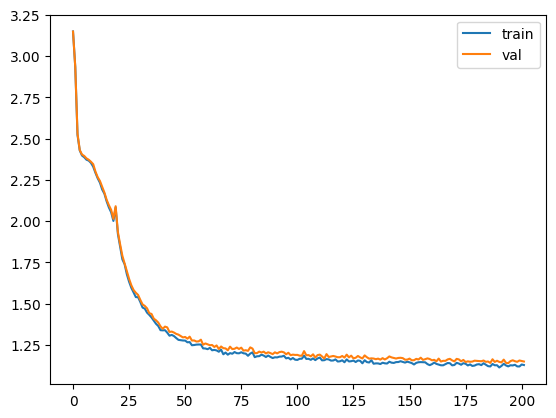

In [37]:
plt.plot([v[1] for v in logs][1:], label='train')
plt.plot([v[2] for v in logs][1:], label='val')
plt.legend()
plt.show()

In [38]:
x_test[0:20]

memmap([ 0, 48, 14, 84,  7, 85, 86, 91,  7, 90, 91, 86, 85, 76, 75,  7,
        73, 92, 91,  7], dtype=uint8)

In [39]:
print(''.join(tokenizer.decode(x_test[0:20])))

[START]I'm not stoned but 


In [40]:
@torch.no_grad()
def generate(idx, max_new_tokens, top_k=None):
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= max_seqlen else idx[:, -max_seqlen:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = -float('Inf')
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        if idx_next == 0: break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [41]:
idx = torch.from_numpy(np.array([x_test[0:20]]).astype(np.int64))
result = generate(idx.to(device), max_new_tokens=1024, top_k=10).detach().cpu().numpy()
result

array([[ 0, 48, 14, 84,  7, 85, 86, 91,  7, 90, 91, 86, 85, 76, 75,  7,
        73, 92, 91,  7, 48, 14, 84,  7, 85, 86, 91,  7, 91, 86,  7, 83,
        72, 91, 76,  7,  7,  3, 48,  7, 83, 86, 93, 76,  7, 80, 91,  7,
         7,  3, 41, 92, 91,  7, 48, 14, 83, 83,  7, 85, 76, 93, 76, 89,
         7, 96, 76, 84, 19,  7, 73, 72, 73, 96,  7,  7,  3,  7,  7,  3,
        48,  7, 94, 72, 85, 85, 72,  7, 90, 94, 86, 89, 83, 75,  7, 94,
        72, 85, 91,  7, 91, 86,  7, 91, 79, 76,  7, 91, 86,  7, 75, 72,
        85, 74, 76,  7,  7,  3, 53, 86, 91, 79, 80, 85, 14,  7, 91, 89,
        92, 76,  7, 96, 86, 92,  7, 82, 85, 76, 94,  7,  7,  3,  7,  7,
         3, 64, 86, 92, 19,  7, 48, 14, 84,  7, 85, 86, 91,  7, 74, 89,
        92, 87, 91, 80, 85, 14,  7, 84, 96,  7, 83, 80, 77, 76,  7,  7,
         3, 41, 92, 91,  7, 48, 14, 84,  7, 85, 86, 91,  7, 90, 91, 72,
        91, 91, 76, 89,  7,  7,  3, 59, 79, 72, 91,  7, 48,  7, 83, 86,
        93, 76,  7, 80, 91, 14, 90,  7, 78, 86, 80, 85, 14,  7, 

In [42]:
decoded_sequence = ''.join(tokenizer.decode(result[0]))
print(decoded_sequence)

[START]I'm not stoned but I'm not to late  
I love it  
But I'll never yem, baby  
  
I wanna sworld want to the to dance  
Nothin' true you knew  
  
You, I'm not cruptin' my life  
But I'm not statter  
That I love it's goin' as taker  
  
Not standed but I want to stay  
But you need as I live  
Your show me to know  
  
I know baby to gotta stake  
  
Insantane  
'chumper week on the line  
One to go,  
The love it's wantin'  
I love it it is teed your showd on  
'caupifalls  
To thing I've been but to got to be?  
It's gon' to dank on thring  
To teet your showlet you wonderfucking?  
I knot to be it's right  
  
I will have a fuges for the terror wains  
It's gotta stander waiting?  
I wanted you all doubout  
  
Something's sho went and ton  
He talk and the night  
Aheow  
She won't wait a stars  
I want and thing  
Oh, ahhhnnight's thing  
  
If I shear you all melody  
That I should say the stop or all be and things  
And the night  
I wanted


